In [53]:
import os
from pathlib import Path, PurePath
import shutil
import pandas as pd
import numpy as np
import cv2
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm import tqdm

In [3]:
input_folder = Path("../Data/APL/")


In [4]:
file_list = [x for x in input_folder.glob('**/*.jpg') if x.is_file()]
print(len(file_list), ".jpg files in input_folder")
file_list[-1]

25722 .jpg files in input_folder


PosixPath('../Data/APL/Patient_02/Signed slides/Smudge cells/SMU_5899611.jpg')

In [113]:
def photo_parser(photo_path):
    """
    Parse a photo_path and identify photo attributes as:
    Patient_Id : int
    Photo_type : str 'Signed' or 'Unsigned'
    cell_type : if Photo_type Signed
    Photo_id : int
    Photo_path : PosixPath or WindowsPath
    Return values in a dict
    """
    path_list = PurePath(photo_path).parts # tuple
    Patient = list(filter(lambda v: re.match('Patient_', v), path_list))
    Photo_type = list(filter(lambda v: re.match('.*slides', v), path_list))[0].split((" "))[0]
    if Photo_type == "Signed":
        cell_type = PurePath(photo_path).parts[-2] # tuple
    else:
        cell_type = None
    Photo_id = list(filter(lambda v: re.match('.*jpg', v), path_list))[0].split('.')[0]
    d = {
        'Patient_ID': str(Patient[0]),
        'Photo_type': Photo_type,
        'Cell_type' : cell_type,
        'Photo_id': Photo_id,
        'Photo_path': photo_path
    }
    return d

In [114]:
i = 0
total_to_import = len(file_list)
dataset = []
for photo_path in file_list:
    photo = photo_parser(photo_path)
    dataset.append(photo)
    i += 1

print(f'{i} photos imported over {total_to_import} ({round(100*i/total_to_import, 2)} %) photos in {input_folder}')
# Import du dataset dans une DF
df = pd.DataFrame(dataset)

25721 photos imported over 25721 (100.0 %) photos in ../Data/APL


In [115]:
print(df.shape)
df.head()

(25721, 5)


,Patient_ID,Photo_type,Cell_type,Photo_id,Photo_path
0,Patient_79,Unsigned,None,10025562151_055,../Data/APL/Patient_79/10025562151/Unsigned sl...
1,Patient_79,Unsigned,None,10025562151_041,../Data/APL/Patient_79/10025562151/Unsigned sl...
2,Patient_79,Unsigned,None,10025562151_040,../Data/APL/Patient_79/10025562151/Unsigned sl...
3,Patient_79,Unsigned,None,10025562151_054,../Data/APL/Patient_79/10025562151/Unsigned sl...
4,Patient_79,Unsigned,None,10025562151_042,../Data/APL/Patient_79/10025562151/Unsigned sl...


In [116]:
df.isna().any()

Patient_ID    False
Photo_type    False
Cell_type      True
Photo_id      False
Photo_path    False
dtype: bool

Merging avec les métadonnées du dataset

In [117]:
APL_meta = pd.read_csv(Path(input_folder / 'master.csv'))
print(APL_meta.shape)
print(APL_meta.isna().any())
APL_meta.head()

(106, 5)
Patient_ID          False
Diagnosis           False
Cohort              False
Age at Diagnosis    False
Gender              False
dtype: bool


,Patient_ID,Diagnosis,Cohort,Age at Diagnosis,Gender
0,Patient_00,APL,Discovery,29,Female
1,Patient_01,AML,Discovery,28,Male
2,Patient_02,AML,Discovery,29,Female
3,Patient_03,AML,Discovery,32,Female
4,Patient_04,AML,Discovery,62,Female


In [118]:
APL = df.merge(right=APL_meta, on="Patient_ID", how='left')
print(APL.shape)
print(APL.isna().any())
APL.head()

(25721, 9)
Patient_ID          False
Photo_type          False
Cell_type            True
Photo_id            False
Photo_path          False
Diagnosis           False
Cohort              False
Age at Diagnosis    False
Gender              False
dtype: bool


,Patient_ID,Photo_type,Cell_type,Photo_id,Photo_path,Diagnosis,Cohort,Age at Diagnosis,Gender
0,Patient_79,Unsigned,None,10025562151_055,../Data/APL/Patient_79/10025562151/Unsigned sl...,APL,Discovery,29,Male
1,Patient_79,Unsigned,None,10025562151_041,../Data/APL/Patient_79/10025562151/Unsigned sl...,APL,Discovery,29,Male
2,Patient_79,Unsigned,None,10025562151_040,../Data/APL/Patient_79/10025562151/Unsigned sl...,APL,Discovery,29,Male
3,Patient_79,Unsigned,None,10025562151_054,../Data/APL/Patient_79/10025562151/Unsigned sl...,APL,Discovery,29,Male
4,Patient_79,Unsigned,None,10025562151_042,../Data/APL/Patient_79/10025562151/Unsigned sl...,APL,Discovery,29,Male


Statistiques sur les images

In [121]:
def images_stats(photo_path):
    """
    Load an image from photo_path and compute :
    H : Height of the image
    W: Width of the image
    'col'_max : max value of channel 'col'
    'col'_min : min value of chenel 'col
    'col'_mean : mean value of chanel 'col'
    """
    #print(photo_path)
    img = cv2.imread(str(photo_path), cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    #plt.imshow(img);
    
    d = {}
    for i in range(2):
        d[str('H')] = img.shape[0]
        d[str('W')] = img.shape[1]

    colors = ['red', 'green', 'blue']
    for i, col in enumerate(colors):
        d[str(col + '_' + 'max')] = np.max(img[:,:,i])
        d[str(col + '_' + 'min')] = np.min(img[:,:,i])
        d[str(col + '_' + 'mean')] = np.mean(img[:,:,i])
        #d[str(col + '_' + 'hist')] = cv2.calcHist(img,[i],None,[256],[0,256])

    return d

In [ ]:
stats_df = APL['Photo_path'].apply(lambda x: pd.Series(images_stats(x)))

Il a fallut éliminer 3 images dont le fichier était corrompu : 

10026627597_066.jpg

10027563503_130.jpg

10027883368_121.jpg

In [122]:
stats_df.head()

,H,W,red_max,red_min,red_mean,green_max,green_min,green_mean,blue_max,blue_min,blue_mean
0,363.0,360.0,255.0,49.0,223.319689,255.0,2.0,190.806305,218.0,79.0,181.048056
1,363.0,360.0,255.0,46.0,210.868258,255.0,5.0,174.971954,219.0,102.0,174.653482
2,363.0,360.0,255.0,44.0,223.690220,250.0,0.0,191.877456,217.0,84.0,183.684183
3,363.0,360.0,255.0,47.0,206.964134,251.0,4.0,172.046166,216.0,97.0,172.231359
4,363.0,360.0,255.0,39.0,212.896227,255.0,1.0,177.542883,215.0,98.0,176.521327


In [123]:
APL = pd.concat([APL, stats_df], axis=1)
print(APL.shape)
APL.head()

(25721, 20)


,Patient_ID,Photo_type,Cell_type,Photo_id,Photo_path,Diagnosis,Cohort,Age at Diagnosis,Gender,H,W,red_max,red_min,red_mean,green_max,green_min,green_mean,blue_max,blue_min,blue_mean
0,Patient_79,Unsigned,None,10025562151_055,../Data/APL/Patient_79/10025562151/Unsigned sl...,APL,Discovery,29,Male,363.0,360.0,255.0,49.0,223.319689,255.0,2.0,190.806305,218.0,79.0,181.048056
1,Patient_79,Unsigned,None,10025562151_041,../Data/APL/Patient_79/10025562151/Unsigned sl...,APL,Discovery,29,Male,363.0,360.0,255.0,46.0,210.868258,255.0,5.0,174.971954,219.0,102.0,174.653482
2,Patient_79,Unsigned,None,10025562151_040,../Data/APL/Patient_79/10025562151/Unsigned sl...,APL,Discovery,29,Male,363.0,360.0,255.0,44.0,223.690220,250.0,0.0,191.877456,217.0,84.0,183.684183
3,Patient_79,Unsigned,None,10025562151_054,../Data/APL/Patient_79/10025562151/Unsigned sl...,APL,Discovery,29,Male,363.0,360.0,255.0,47.0,206.964134,251.0,4.0,172.046166,216.0,97.0,172.231359
4,Patient_79,Unsigned,None,10025562151_042,../Data/APL/Patient_79/10025562151/Unsigned sl...,APL,Discovery,29,Male,363.0,360.0,255.0,39.0,212.896227,255.0,1.0,177.542883,215.0,98.0,176.521327


APL only signed photos

In [124]:
APL_signed = APL.dropna()
print(APL_signed.shape)
print(APL_signed.isna().any())
APL_signed.head()

(15632, 20)
Patient_ID          False
Photo_type          False
Cell_type           False
Photo_id            False
Photo_path          False
Diagnosis           False
Cohort              False
Age at Diagnosis    False
Gender              False
H                   False
W                   False
red_max             False
red_min             False
red_mean            False
green_max           False
green_min           False
green_mean          False
blue_max            False
blue_min            False
blue_mean           False
dtype: bool


,Patient_ID,Photo_type,Cell_type,Photo_id,Photo_path,Diagnosis,Cohort,Age at Diagnosis,Gender,H,W,red_max,red_min,red_mean,green_max,green_min,green_mean,blue_max,blue_min,blue_mean
60,Patient_79,Signed,"Blast, no lineage spec",BL_11301990,../Data/APL/Patient_79/10025562151/Signed slid...,APL,Discovery,29,Male,363.0,360.0,255.0,45.0,220.330663,244.0,6.0,186.874587,211.0,101.0,181.339501
61,Patient_79,Signed,"Blast, no lineage spec",BL_11301957,../Data/APL/Patient_79/10025562151/Signed slid...,APL,Discovery,29,Male,363.0,360.0,255.0,50.0,213.374824,255.0,0.0,178.800199,218.0,101.0,179.550122
62,Patient_79,Signed,"Blast, no lineage spec",BL_11301968,../Data/APL/Patient_79/10025562151/Signed slid...,APL,Discovery,29,Male,363.0,360.0,255.0,40.0,201.104752,251.0,5.0,164.599204,216.0,89.0,170.706076
63,Patient_79,Signed,"Blast, no lineage spec",BL_11301948,../Data/APL/Patient_79/10025562151/Signed slid...,APL,Discovery,29,Male,363.0,360.0,255.0,44.0,209.459389,255.0,0.0,172.973209,223.0,101.0,176.484948
64,Patient_79,Signed,Band neutrophils,BNE_11301955,../Data/APL/Patient_79/10025562151/Signed slid...,APL,Discovery,29,Male,363.0,360.0,255.0,41.0,207.606987,255.0,4.0,168.666192,221.0,97.0,171.913812


Write csv file

In [125]:
APL.to_csv('../Data/APL/APL.csv', index=False)

## Séparation du jeu de données APL en 13 classes et conversion en png

In [61]:
input_folder = Path("../Data/APL/")
output_folder = Path("../Data/APL_13cat")

output_folder.mkdir(exist_ok=True)

for file in input_folder.glob('**/*.jpg'):
    if file.is_file() and not file.name.startswith('.'):
        # Include only identified blood cells
        if file.parts[-3] == 'Signed slides':
            tag = file.parts[-1].split('_')[0]
            file_name = file.parts[-1].split('.')[0]
            # Elimination des PLY qui n'ont qu'une image
            # BL : Blast non identifiés
            # ART : arifact of manipulation
            # VLY : lymphocytes variants
            # PC : plasma cells non identifiés
            # USRWBC2_ : young unidentifieds
            # UI : Unidentified
            # ERC : Throbocyte aggregation
            if tag not in ['PLY', 'BL', 'ART', 'VLY', 'PC', 'USRWBC2', 'UI', 'ERC']:
                # read image
                image = cv2.imread(str(file), cv2.IMREAD_COLOR)
                Path(output_folder / tag).mkdir(exist_ok=True)
                save_path = Path(output_folder / tag /
                                 str(str(file_name) + '.png'))
                # Convert the image in png and save
                cv2.imwrite(str(save_path), image)


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


### Renomage des dossiers avec les catégories équivalentes à PBC

In [62]:
renommer_dossiers = {
    # APL : PBC
    'BA': 'BA',
    'BNE': 'BNE',
    'EO': 'EO',
    'ERB': 'ERB',
    'GT': 'PLT',
    'LY': 'LY',
    'MMY': 'MMY',
    'MO': 'MO',
    'MY': 'MY',
    'PMO': 'PMO',
    'PMY': 'PMY',
    'SMU': 'SMU',
    'SNE': 'SNE',
}
dossier_parent = Path("../Data/APL_13cat")
for dossier in dossier_parent.iterdir():
    if dossier.is_dir() and dossier.name in renommer_dossiers:
        nouveau_nom = renommer_dossiers[dossier.name]
        nouveau_chemin = dossier_parent / nouveau_nom
        dossier.rename(nouveau_chemin)


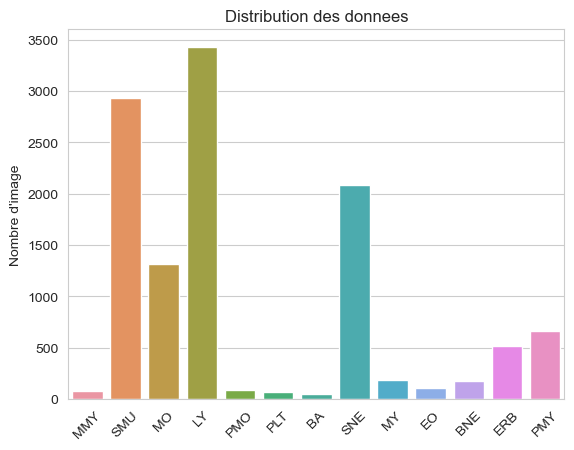

In [63]:
path = Path("../Data/APL_13cat")

subdirs = [name for name in os.listdir(
    path) if os.path.isdir(os.path.join(path, name))]

# Count the number of files in each subdirectory
file_counts = [len(os.listdir(os.path.join(path, subdir)))
               for subdir in subdirs]

sns.set_style("whitegrid")
sns.barplot(x=subdirs, y=file_counts)
plt.ylabel("Nombre d'image")
plt.title("Distribution des donnees")
plt.xticks(rotation=45)
plt.show()


## Création d'un échatillon

In [64]:
import random
sample_length = 5

input_folder = Path("../Data/APL_13cat")
output_folder = Path("../Data/APL_sample")

output_folder.mkdir(exist_ok=True)

for subdir in input_folder.iterdir():
    if subdir.is_dir():
        # print(subdir)
        tag = subdir.parts[-1]
        files = [i for i in subdir.glob('**/*.png') if i.is_file()]
        sample = random.sample(files, sample_length)

        # copy sample in output folder
        for file in sample:
            # print(file)
            tag_folder = output_folder/tag
            # print(tag_folder)
            tag_folder.mkdir(exist_ok=True)
            file_name = file.parts[-1]
            # print(file_name)
            shutil.copy(file, tag_folder/file_name)
